In [40]:
import numpy as np
import os
from pathlib import Path

import matplotlib.pyplot as plt
from keras.preprocessing import image

In [41]:
p = Path("train-dataset/")
dirs = p.glob("*")

labels_dict = {'IBM Plex Sans Arabic':0, 'Lemonada':1, 'Marhey':2, 'Scheherazade New': 3}

image_data = []
labels = []    

for folder_dir in dirs:
    label = folder_dir.name # dir names are the labels
    
    for img_path in folder_dir.glob("*.jpeg"):
        img = image.load_img(img_path, target_size=(512,512))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])

In [42]:
print(len(image_data))
print(len(labels))

89
89


In [43]:
image_data = np.array(image_data, dtype='float32')/255.0
labels = np.array(labels)

print(image_data.shape, labels.shape)

(89, 512, 512, 3) (89,)


In [44]:
## Randomly shuffle data

import random 
combined = list(zip(image_data, labels))
random.shuffle(combined)

image_data[:], labels[:] = zip(*combined)

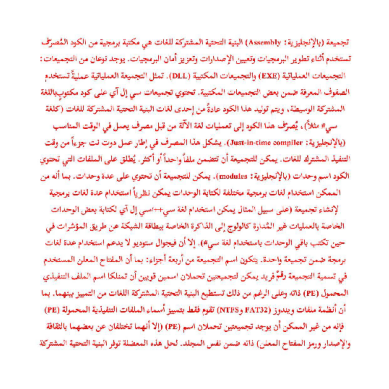

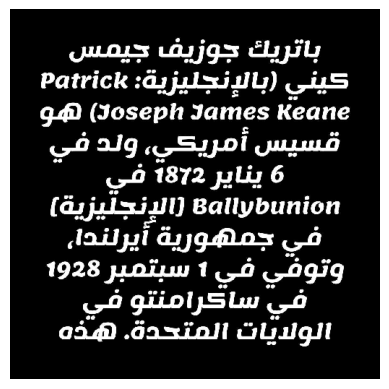

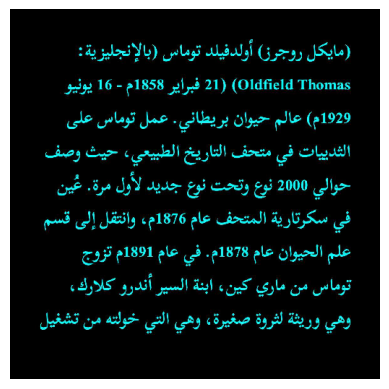

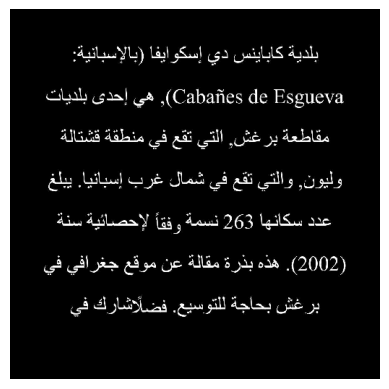

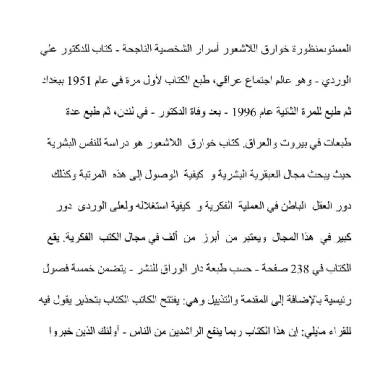

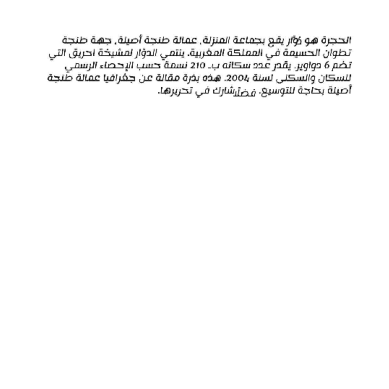

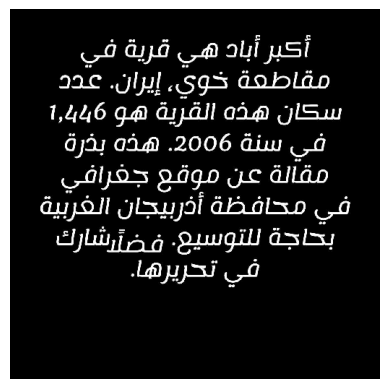

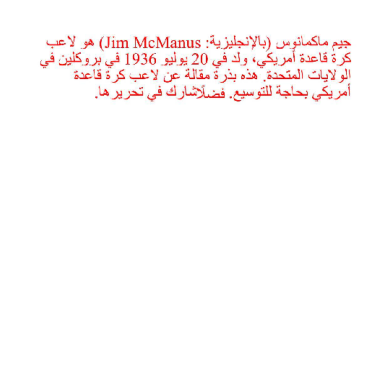

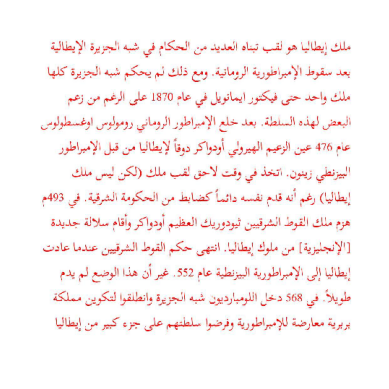

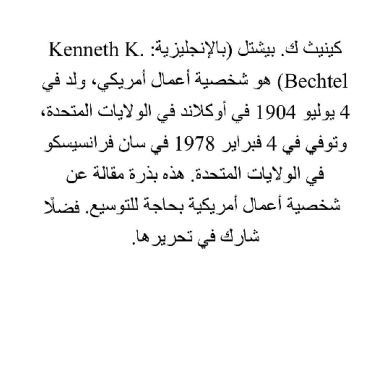

In [45]:
## Visualize the data

def drawImg(img):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

for i in range(10):
    drawImg(image_data[i])

In [46]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update rule
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

In [47]:
## Data conversion for One vs One classification

M = image_data.shape[0]
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

(89, 786432)
(89,)


In [48]:
number_of_classes = len(np.unique(labels))
print(number_of_classes)

4


In [49]:
def classWiseData(x, y):
    data = {}
    
    for i in range(number_of_classes):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [50]:
data = classWiseData(image_data, labels)

In [51]:
print(data[0].shape[0])
print(data[1].shape[0])
print(data[2].shape[0])
print(data[3].shape[0])

13
27
34
15


In [52]:
"""Combines data of two classes into a single matrix"""
def getDataPairForSVM(d1,d2):
    
    l1,l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = 1
    
    return data_pair, data_labels

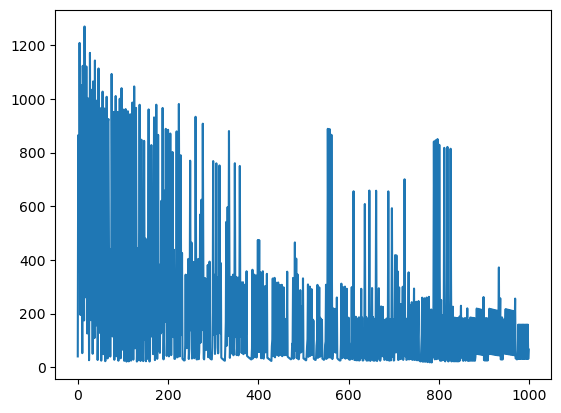

In [53]:
mySVM = SVM()
xp, yp = getDataPairForSVM(data[0], data[1])
w,b,loss = mySVM.fit(xp,yp,learning_rate=0.00001,maxItr=1000)
plt.plot(loss)

In [56]:
def trainSVMs(x,y):
    svm_classifiers = {}
    
    for i in range(number_of_classes):
        svm_classifiers[i] = {}
        for j in range(i+1, number_of_classes):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair, ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
            
            # plt.plot(loss)
            # plt.show()
            
    return svm_classifiers

In [57]:
svm_classifiers = trainSVMs(image_data, labels)

In [58]:
#save classifier to use it later
import pickle

with open('svm_classifiers.pkl', 'wb') as f:
    pickle.dump(svm_classifiers, f)
# Load SVM classifiers from file
def loadSVMClassifiers(filename):
    with open(filename, 'rb') as f:
        svm_classifiers = pickle.load(f)
    return svm_classifiers

loaded_svm_classifiers = loadSVMClassifiers('svm_classifiers.pkl')

In [68]:
# Get the shape of svm_classifiers (number of keys)
svm_classifiers_shape = len(svm_classifiers)
print("Shape of svm_classifiers:", svm_classifiers_shape)

# Get the shape of each array within svm_classifiers
for i in range(svm_classifiers_shape):
    for j in svm_classifiers[i]:
        print("Shape of array at svm_classifiers[{}][{}]: {}".format(i, j, svm_classifiers[i][j][0].shape))

Shape of svm_classifiers: 4
Shape of array at svm_classifiers[0][1]: (1, 786432)
Shape of array at svm_classifiers[0][2]: (1, 786432)
Shape of array at svm_classifiers[0][3]: (1, 786432)
Shape of array at svm_classifiers[1][2]: (1, 786432)
Shape of array at svm_classifiers[1][3]: (1, 786432)
Shape of array at svm_classifiers[2][3]: (1, 786432)


In [67]:

IBM_Lemonada = svm_classifiers[0][1]
Lemonada_Marhey = svm_classifiers[0][3]
print(IBM_Lemonada[0].shape)
print(IBM_Lemonada[1])

Class 0 has 3 inner classes.
Class 1 has 2 inner classes.
Class 2 has 1 inner classes.
Class 3 has 0 inner classes.
Number of classes: 4
(1, 786432)
-0.0002500000000000007


In [60]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    if z >= 0:
        return 1
    else:
        return -1
    

In [61]:
def predict(x):
    
    count = np.zeros((number_of_classes,))
    
    for i in range(number_of_classes):
        for j in range(i+1, number_of_classes):
            w,b = svm_classifiers[i][j]
            
            #Take a majority prediction
            z = binaryPredict(x,w,b)
            
            if z==1:
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    return final_prediction

In [62]:
print(predict(image_data[0]))
print(labels[0])

3
3


In [63]:
def accuracy(x,y):
    
    pred = []
    count=0
    
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        pred.append(prediction)
        if prediction==y[i]:
            count += 1
    
    return count/x.shape[0], pred

In [64]:
acc, ypred = accuracy(image_data, labels)
print(acc)

0.5955056179775281
